<a href="https://colab.research.google.com/github/appletreeleaf/Study_Log/blob/NLP/%5BHW26_Problem%5DWord2Vec_%EC%9D%B4%EC%9E%AC%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**3. Word2Vec**
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 만듭니다.
2. CBOW, Skip-gram 모델을 각각 구현합니다.
3. 모델을 실제로 학습해보고 결과를 확인합니다.
4. 산점도를 그려 단어들의 대략적인 위치를 확인해봅니다

### **필요 패키지 import**

In [ ]:

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 2s (5,570 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 39.7 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
from konlpy.tag import Mecab,Twitter,Okt,Kkma
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### **데이터 전처리**



데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.  

In [ ]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

Tokenization과 vocab을 만드는 과정은 이전 실습과 유사합니다.

## 1. Tokenization

In [ ]:
tokenizer = Okt() # 품사태깅

In [ ]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data):
    tokens = tokenizer.morphs(sent, stem=True) # token을 품사 단위로 바꿔줌 ex) 맛있습니다 -> 맛있다
    tokenized.append(tokens)

  return tokenized

In [ ]:
train_tokenized = make_tokenized(train_data)

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


In [ ]:
# 문장들이 품사 단위로 나눠지는 것을 볼 수 있습니다.
print(train_tokenized)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]


In [ ]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1 # token의 빈도를 측정

100%|██████████| 10/10 [00:00<00:00, 73326.99it/s]


In [ ]:
word_count.items()

dict_items([('정말', 1), ('맛있다', 1), ('.', 14), ('추천', 1), ('하다', 2), ('기대하다', 1), ('것', 1), ('보단', 1), ('별로', 3), ('이다', 4), ('다', 3), ('좋다', 4), ('가격', 1), ('이', 3), ('너무', 3), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('방문', 2), ('의사', 1), ('있다', 1), ('음식', 3), ('도', 7), ('서비스', 3), ('만족스럽다', 1), ('위생', 2), ('상태', 1), ('가', 1), ('좀', 2), ('더', 2), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('에', 2), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('조금', 2), ('신경', 1), ('써다', 1), ('불쾌하다', 1)])

In [ ]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True) #tuple
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


In [ ]:
w2i = {} # tuple to dict
for pair in tqdm(word_count):
  if pair[0] not in w2i:    # (word, frequency)이므로 pair[0] == word
    w2i[pair[0]] = len(w2i) # 헤당 word가 word2idx dict에 없다면, update하고 index부여   *len(w2i)는 0,1,2.... 즉 0부터 idx부여

i2w={v:k for k,v in w2i.items()} # 위의 역과정

100%|██████████| 60/60 [00:00<00:00, 305410.49it/s]


### 다음은 Word2Vec을 학습시키는 대표적인 방법인 Skipgram과 CBoW를 다룹니다.

* CboW는 주변단어를 이용해, 주어진 단어를 예측하는 방법입니다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법입니다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있습니다.

참고자료

* https://simonezz.tistory.com/35

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314



실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

In [ ]:
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]    # word에 대응되는 index값들이 들어있음
      for i, id in enumerate(token_ids): # i=단어위치, id=단어의 정수 인덱스값
        if i-window_size >= 0 and i+window_size < len(token_ids):
          ############################ ANSWER HERE ################################
          # TODO 1: insert tokens for input self.x
          # TODO 2: insert tokens for targets self.y
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+1+window_size])
          self.y.append(id)
          #########################################################################

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = []

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
            ############################ ANSWER HERE ################################
          # TODO 1: insert tokens for input self.x
          # TODO 2: insert tokens for targets self.y
          self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1]) # append랑 +=한거랑 차이가 있나?
          self.x += [id] * 2 * window_size
          #########################################################################


    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [ ]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
print(list(skipgram_set))

100%|██████████| 10/10 [00:00<00:00, 41241.93it/s]

[(tensor(0), tensor(17)), (tensor(0), tensor(18)), (tensor(0), tensor(19)), (tensor(0), tensor(10)), (tensor(19), tensor(18)), (tensor(19), tensor(0)), (tensor(19), tensor(10)), (tensor(19), tensor(0)), (tensor(22), tensor(20)), (tensor(22), tensor(21)), (tensor(22), tensor(4)), (tensor(22), tensor(2)), (tensor(4), tensor(21)), (tensor(4), tensor(22)), (tensor(4), tensor(2)), (tensor(4), tensor(0)), (tensor(23), tensor(5)), (tensor(23), tensor(3)), (tensor(23), tensor(6)), (tensor(23), tensor(7)), (tensor(6), tensor(3)), (tensor(6), tensor(23)), (tensor(6), tensor(7)), (tensor(6), tensor(24)), (tensor(7), tensor(23)), (tensor(7), tensor(6)), (tensor(7), tensor(24)), (tensor(7), tensor(25)), (tensor(24), tensor(6)), (tensor(24), tensor(7)), (tensor(24), tensor(25)), (tensor(24), tensor(26)), (tensor(25), tensor(7)), (tensor(25), tensor(24)), (tensor(25), tensor(26)), (tensor(25), tensor(27)), (tensor(26), tensor(24)), (tensor(26), tensor(25)), (tensor(26), tensor(27)), (tensor(26), tens

### **모델 Class 구현**

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [ ]:
q = torch.ones(2,3)
q

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [ ]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True) # vocab_size 크기의 one-hot vector를 우리가 지정한 dimension으로 embedding
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    ##### 위에서 아래로 dim이 바뀐 이유를 모르겠네
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [ ]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim):
    super(SkipGram, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

두 가지 모델을 생성합니다.

In [ ]:
cbow = CBOW(vocab_size=len(w2i), dim=256) # vocab_size = unique word = w2i dictionary의 단어 수(크기,길이이)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### **모델 학습**

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

In [ ]:
batch_size=4
learning_rate = 5e-4
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.

In [ ]:
cbow.train()
cbow = cbow.to(device) # to gpu
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate) #optimizer
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(cbow_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)

    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

    print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 16/16 [00:03<00:00,  5.20it/s]


Train loss: 4.312560081481934
Train loss: 4.706026554107666
Train loss: 5.215273380279541
Train loss: 4.611527442932129
Train loss: 5.4254045486450195
Train loss: 5.705330848693848
Train loss: 4.925873279571533
Train loss: 4.497958183288574
Train loss: 4.609296798706055
Train loss: 4.395036220550537
Train loss: 4.352705001831055
Train loss: 5.094509124755859
Train loss: 3.2858364582061768
Train loss: 4.741290092468262
Train loss: 6.013391971588135
Train loss: 4.65230131149292
##################################################
Epoch: 2


100%|██████████| 16/16 [00:00<00:00, 610.76it/s]


Train loss: 4.138981819152832
Train loss: 4.547187328338623
Train loss: 5.084856033325195
Train loss: 4.486894607543945
Train loss: 5.283964157104492
Train loss: 5.450082302093506
Train loss: 4.711617469787598
Train loss: 4.33994197845459
Train loss: 4.490058898925781
Train loss: 4.212679386138916
Train loss: 4.203240871429443
Train loss: 4.767696380615234
Train loss: 3.175046443939209
Train loss: 4.593456268310547
Train loss: 5.8508076667785645
Train loss: 4.491775035858154
##################################################
Epoch: 3


100%|██████████| 16/16 [00:00<00:00, 600.52it/s]


Train loss: 3.9697749614715576
Train loss: 4.393424034118652
Train loss: 4.956082344055176
Train loss: 4.365739345550537
Train loss: 5.1449174880981445
Train loss: 5.2004523277282715
Train loss: 4.506065368652344
Train loss: 4.1862335205078125
Train loss: 4.374305725097656
Train loss: 4.0347700119018555
Train loss: 4.058470249176025
Train loss: 4.450901985168457
Train loss: 3.0661864280700684
Train loss: 4.454350471496582
Train loss: 5.690592288970947
Train loss: 4.340354919433594
##################################################
Epoch: 4


  0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 3.804551362991333
Train loss: 4.244121074676514
Train loss: 4.828907012939453
Train loss: 4.247568130493164
Train loss: 5.008188247680664
Train loss: 4.956947326660156
Train loss: 4.30853796005249
Train loss: 4.036670684814453
Train loss: 4.262054920196533
Train loss: 3.8616323471069336
Train loss: 3.9187569618225098
Train loss: 4.145650863647461
Train loss: 2.9592394828796387


100%|██████████| 16/16 [00:00<00:00, 51.28it/s]


Train loss: 4.3225812911987305
Train loss: 5.532642841339111
Train loss: 4.196422576904297
##################################################
Epoch: 5


100%|██████████| 16/16 [00:00<00:00, 540.03it/s]

Train loss: 3.6430931091308594
Train loss: 4.098860740661621
Train loss: 4.703300476074219
Train loss: 4.132038593292236
Train loss: 4.87372350692749
Train loss: 4.72025728225708
Train loss: 4.118520259857178
Train loss: 3.891141891479492
Train loss: 4.153350353240967
Train loss: 3.6936380863189697
Train loss: 3.7845304012298584
Train loss: 3.8537731170654297
Train loss: 2.854238271713257
Train loss: 4.197100639343262
Train loss: 5.376893997192383
Train loss: 4.058853626251221
Finished.


다음으로 Skip-gram 모델 학습입니다.

In [ ]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()
for e in range(1, num_epochs+1):
  print("#" * 50)
  print(f"Epoch: {e}")
  for batch in tqdm(skipgram_loader):
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = skipgram(x)  # (B, V)

    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Train loss: {loss.item()}")

print("Finished.")

##################################################
Epoch: 1


100%|██████████| 64/64 [00:00<00:00, 986.82it/s]


Train loss: 4.7847466468811035
##################################################
Epoch: 2


100%|██████████| 64/64 [00:00<00:00, 1098.05it/s]


Train loss: 4.732769966125488
##################################################
Epoch: 3


100%|██████████| 64/64 [00:00<00:00, 1048.40it/s]


Train loss: 4.681147575378418
##################################################
Epoch: 4


100%|██████████| 64/64 [00:00<00:00, 1074.36it/s]


Train loss: 4.629892826080322
##################################################
Epoch: 5


100%|██████████| 64/64 [00:00<00:00, 1070.72it/s]

Train loss: 4.579020023345947
Finished.


### **테스트**

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [ ]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device) # test_words의 word들을 index값으로 변환 후 torch.LongTensor 변환 후 gpu로 보냄냄
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(emb.squeeze(0))

Word: 음식
tensor([ 0.6124, -0.0123,  1.1840, -0.1200,  0.0866,  0.0493,  1.3134, -1.3995,
         1.0501, -1.0432,  0.0651,  0.6847,  0.0682, -0.3326, -0.5170, -0.7117,
         0.2705,  0.5727,  1.4585, -0.1662,  2.0853, -1.0293, -0.0393,  1.7251,
         0.6467,  0.6998,  0.7572, -0.4284,  1.0301, -0.0747, -2.4505,  0.8699,
         0.6280, -0.3213, -0.4516,  0.0640,  0.5933, -1.2895,  2.3883,  0.2088,
        -0.6019, -1.5515, -1.7922, -1.2726, -2.1368, -1.6793,  0.2320,  0.2062,
         0.3506,  0.5164,  0.0775,  0.7151, -1.3907, -0.5931, -0.2518,  1.4562,
         1.8961,  0.4993, -0.9746,  1.8871,  0.7030,  0.0398,  0.5138, -0.5946,
         1.8336,  1.8695,  0.3665,  1.1417,  0.5302, -1.1870,  0.1154,  0.3861,
         1.0715,  1.0872,  0.4305, -0.0846,  0.6982,  0.3231, -0.1420,  0.1782,
        -1.8644,  0.0258,  1.0901,  0.3801, -0.3710,  1.3006,  0.7586, -1.0695,
        -1.0924,  1.2853,  1.3836, -1.3088,  1.2804, -0.0943, -0.9306, -1.7242,
        -0.0034,  0.9482,  0.12

In [ ]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0))) # longtensor였던 임베딩벡터를 매트릭스형태로 변형하고 그중 가장 큰 원소값을 출력력

Word: 음식
tensor(2.5706, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 맛
tensor(2.6047, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(2.9573, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 위생
tensor(2.7450, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 가격
tensor(3.7445, device='cuda:0', grad_fn=<UnbindBackward0>)


In [ ]:
test_words

['음식', '맛', '서비스', '위생', '가격']

In [ ]:
i2w[25]

'다시'

In [ ]:
def most_similar(word,top_k=5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score=torch.matmul(input_emb,skipgram.embedding.weight.transpose(1,0)).view(-1)

  _,top_k_ids=torch.topk(score,top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:]

In [ ]:
most_similar("맛")

['이', '방문', '기념일', '개선']

## Word2Vec 시각화

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='NanumBarunGothic')
#plt.rc('font', family='AppleGothic') #맥

In [ ]:
pca=PCA(n_components=2)

In [ ]:
pc_weight=pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text

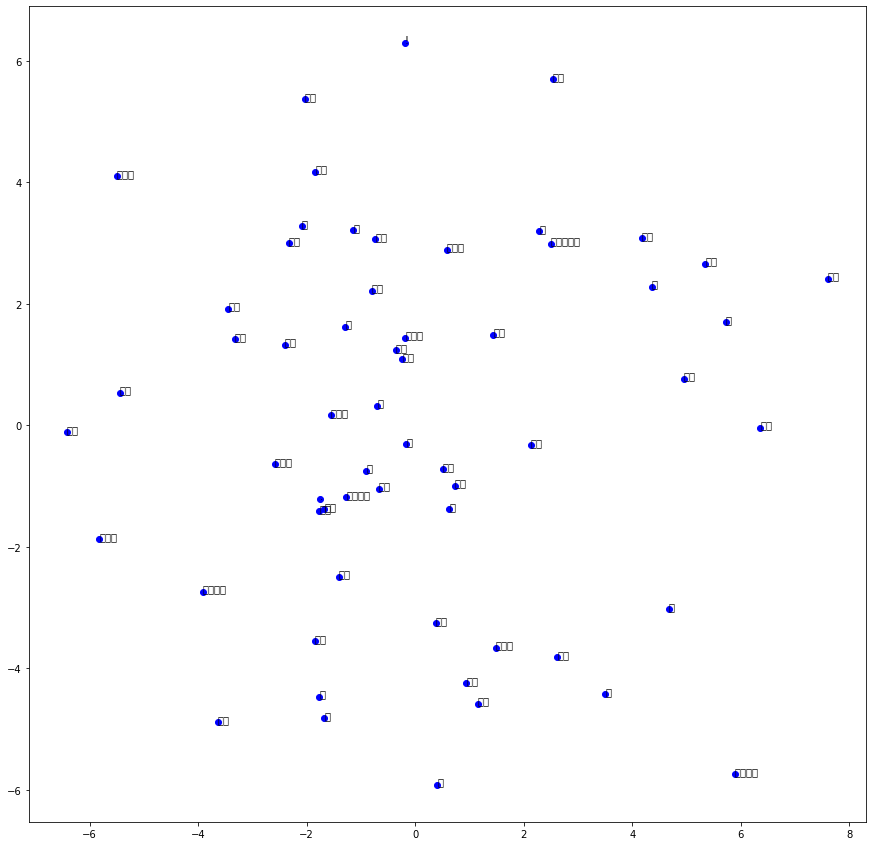

In [ ]:
plt.figure(figsize=(15,15))

for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate, y_coordinate))